In [7]:
import glob
import pathlib

import celltypist
import matplotlib as mpl
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from celltypist import models

%matplotlib inline
from matplotlib import pyplot as plt

params = {
    "font.size": 12,
    "axes.titlesize": 12,
    "axes.labelsize": 12,
    "legend.fontsize": 12,
    "xtick.labelsize": 8,
    "ytick.labelsize": 10,
    "font.family": "Arial",
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "figure.dpi": 100,
}

tissue = "LN"
mpl.rcParams.update(params)
sns.set_style("ticks")
sns.set_context(context="paper")
savefig_args = {
    "dpi": 300,
    "bbox_inches": "tight",
    "pad_inches": 0,
    "transparent": True,
}
mpl.rc("savefig", dpi=300)
output_dir = "figures/QCandAnnotation/{}".format(tissue)
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
output_suffix = ""
output_formats = [".png", ".svg"]
sc.settings.figdir = output_dir
sc.set_figure_params(
    format="pdf",
    transparent=True,
)


def save_figure(
    fig,
    name,
    output_dir=output_dir,
    output_suffix=output_suffix,
    output_formats=output_formats,
    savefig_args=savefig_args,
):
    for output_format in output_formats:
        fig.savefig(
            output_dir + "/" + name + output_suffix + output_format, **savefig_args
        )
    return None


pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 100)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
%run ../_helper.py

In [9]:
def merge_vdj(obs_df, vdj_df):
    vdj_df = vdj_df.reset_index()
    # prepare merge
    vdj_df["cb_suid"] = vdj_df["cb"] + "_" + vdj_df["sample_uid"]
    # remove duplicates
    vdj_df = vdj_df[~vdj_df["cb_suid"].duplicated()]
    obs_df["cb"] = pd.Series(obs_df.index).str.split("-", expand=True)[0].values
    obs_df["cb_suid"] = (
        obs_df["cb"].astype(str) + "_" + obs_df["sample_uid"].astype(str)
    )
    obs_df.set_index("cb_suid", inplace=True)
    vdj_df.set_index("cb_suid", inplace=True)

    # merge
    obs_df = pd.merge(
        obs_df,
        vdj_df,
        left_index=True,
        right_index=True,
        how="left",
        suffixes=[None, "_vdj"],
    )
    return obs_df

In [10]:
vdj_df = pd.read_table(
    "/home/michaelswift/repos/shared_data/tbd_share/vdj_integrated_with_flags.tsv.gz",
    index_col=0,
)

<ipython-input-10-70b9c60b5613>:1: DtypeWarning: Columns (2,3,4,5,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,46,54,56,58,59,60,63,73,74,75,76,77,78,79,82,83,91) have mixed types. Specify dtype option on import or set low_memory=False.
  vdj_df = pd.read_table(


In [205]:
obs_df = pd.read_table("gex_labels.tsv.gz", index_col=0)

In [206]:
obs_df = merge_vdj(obs_df, vdj_df)

In [207]:
obs_df = obs_df[~obs_df.c_call.isna()]
## Naive ambient estimation:
s = {"IGHM":"IGHM|D", "IGHD":"IGHM|D"}
obs_df['switched'] = obs_df.c_call.map(lambda x: s.get(x, 'switched'))
#obs_df['switched'].fillna("switched", inplace=True)

In [208]:
obs_df = obs_df[obs_df.probable_hq_single_b_cell == True]

## Mutation Frequency By Constant Region Gene

### All Cells

<AxesSubplot:xlabel='v_identity', ylabel='tissue'>

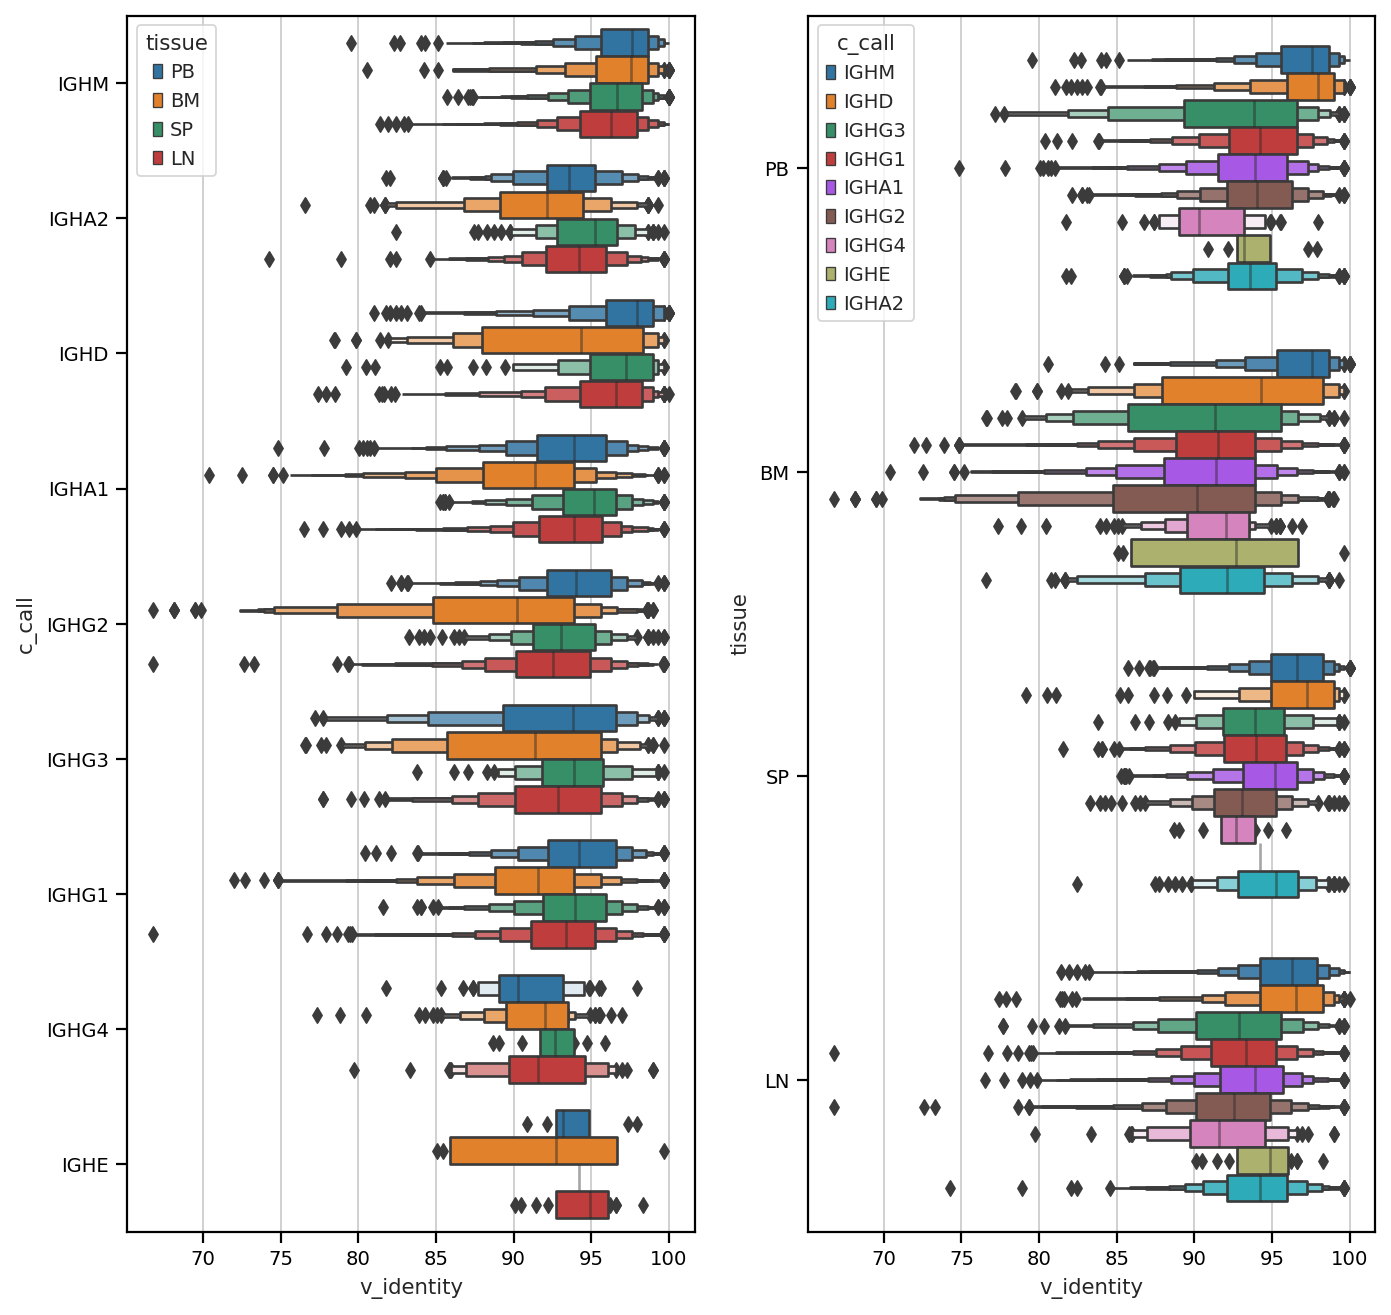

In [209]:
data = obs_df
data = data[data.c_call.isin(igh_genes)]
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
sns.boxenplot(data, y="c_call", x="v_identity", hue="tissue", ax=axs[0])
sns.boxenplot(
    data, y="tissue", x="v_identity", hue="c_call", ax=axs[1], hue_order=igh_genes
)

### Just Plasma Cells

<AxesSubplot:xlabel='v_identity', ylabel='tissue'>

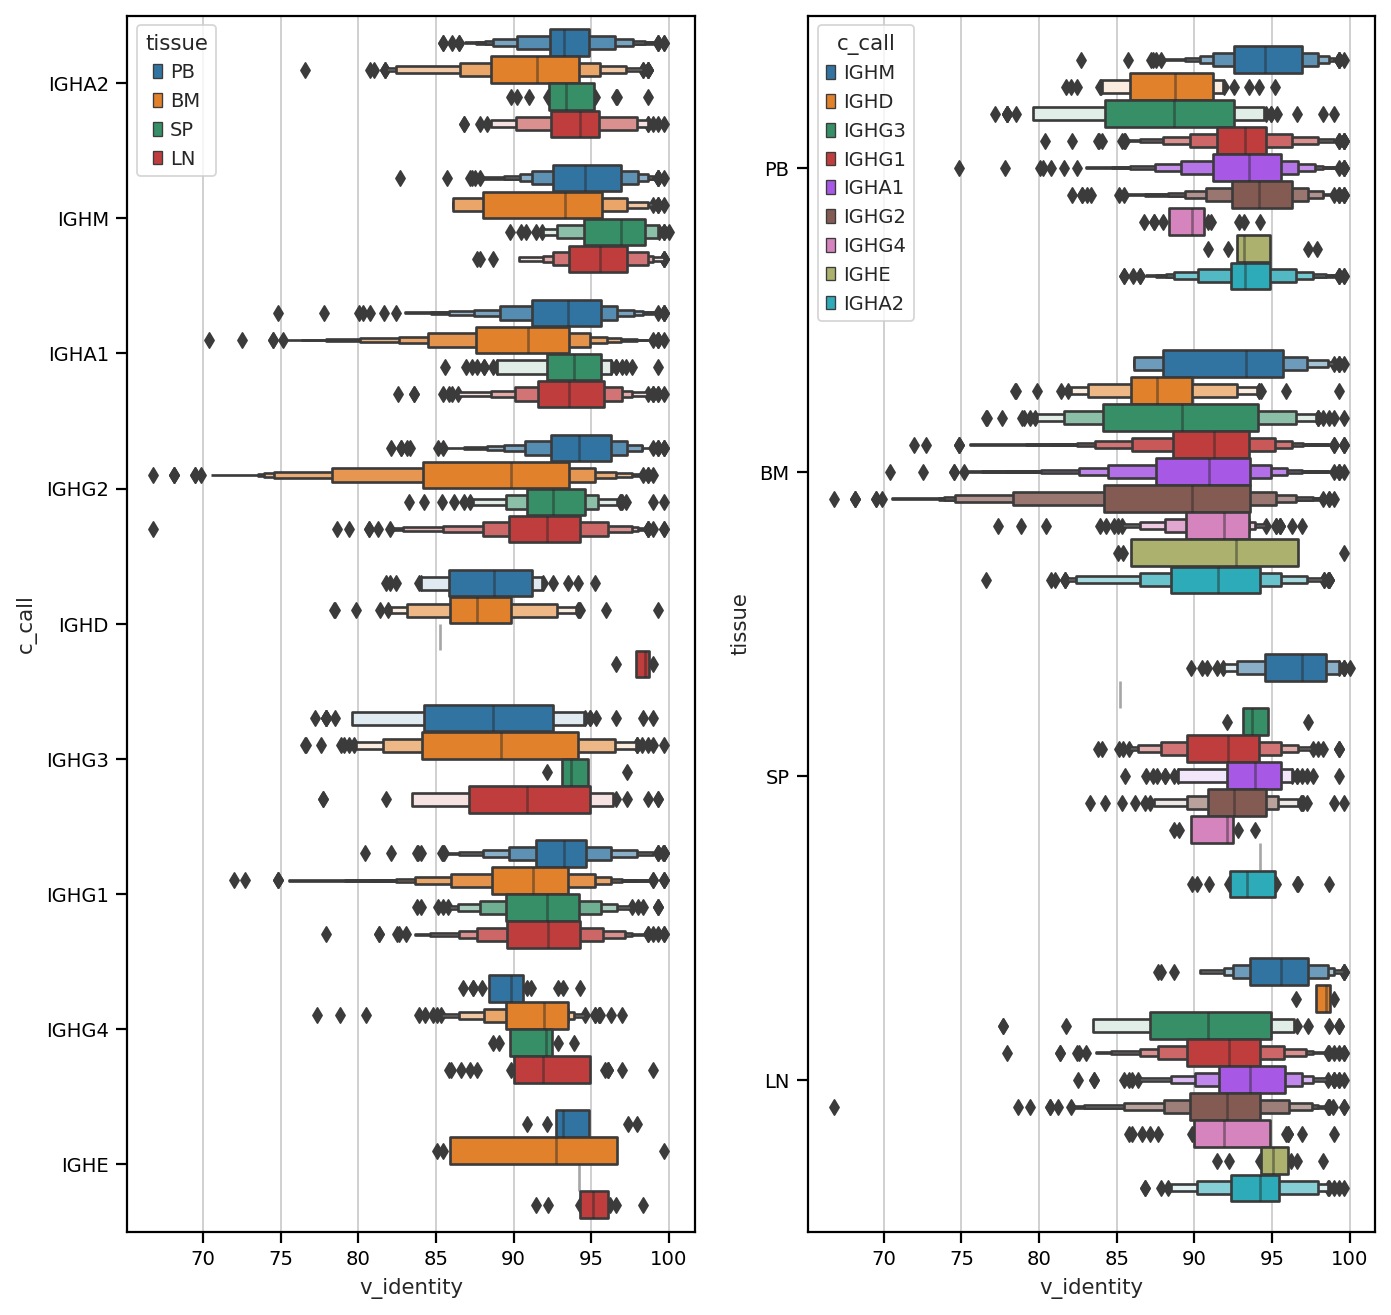

In [213]:
data = obs_df
data = data[data.c_call.isin(igh_genes)]
data = data[data.Immune_All_Low_majority_voting.str.contains('Plasma')]
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
sns.boxenplot(data, y="c_call", x="v_identity", hue="tissue", ax=axs[0])
sns.boxenplot(
    data, y="tissue", x="v_identity", hue="c_call", ax=axs[1], hue_order=igh_genes
)

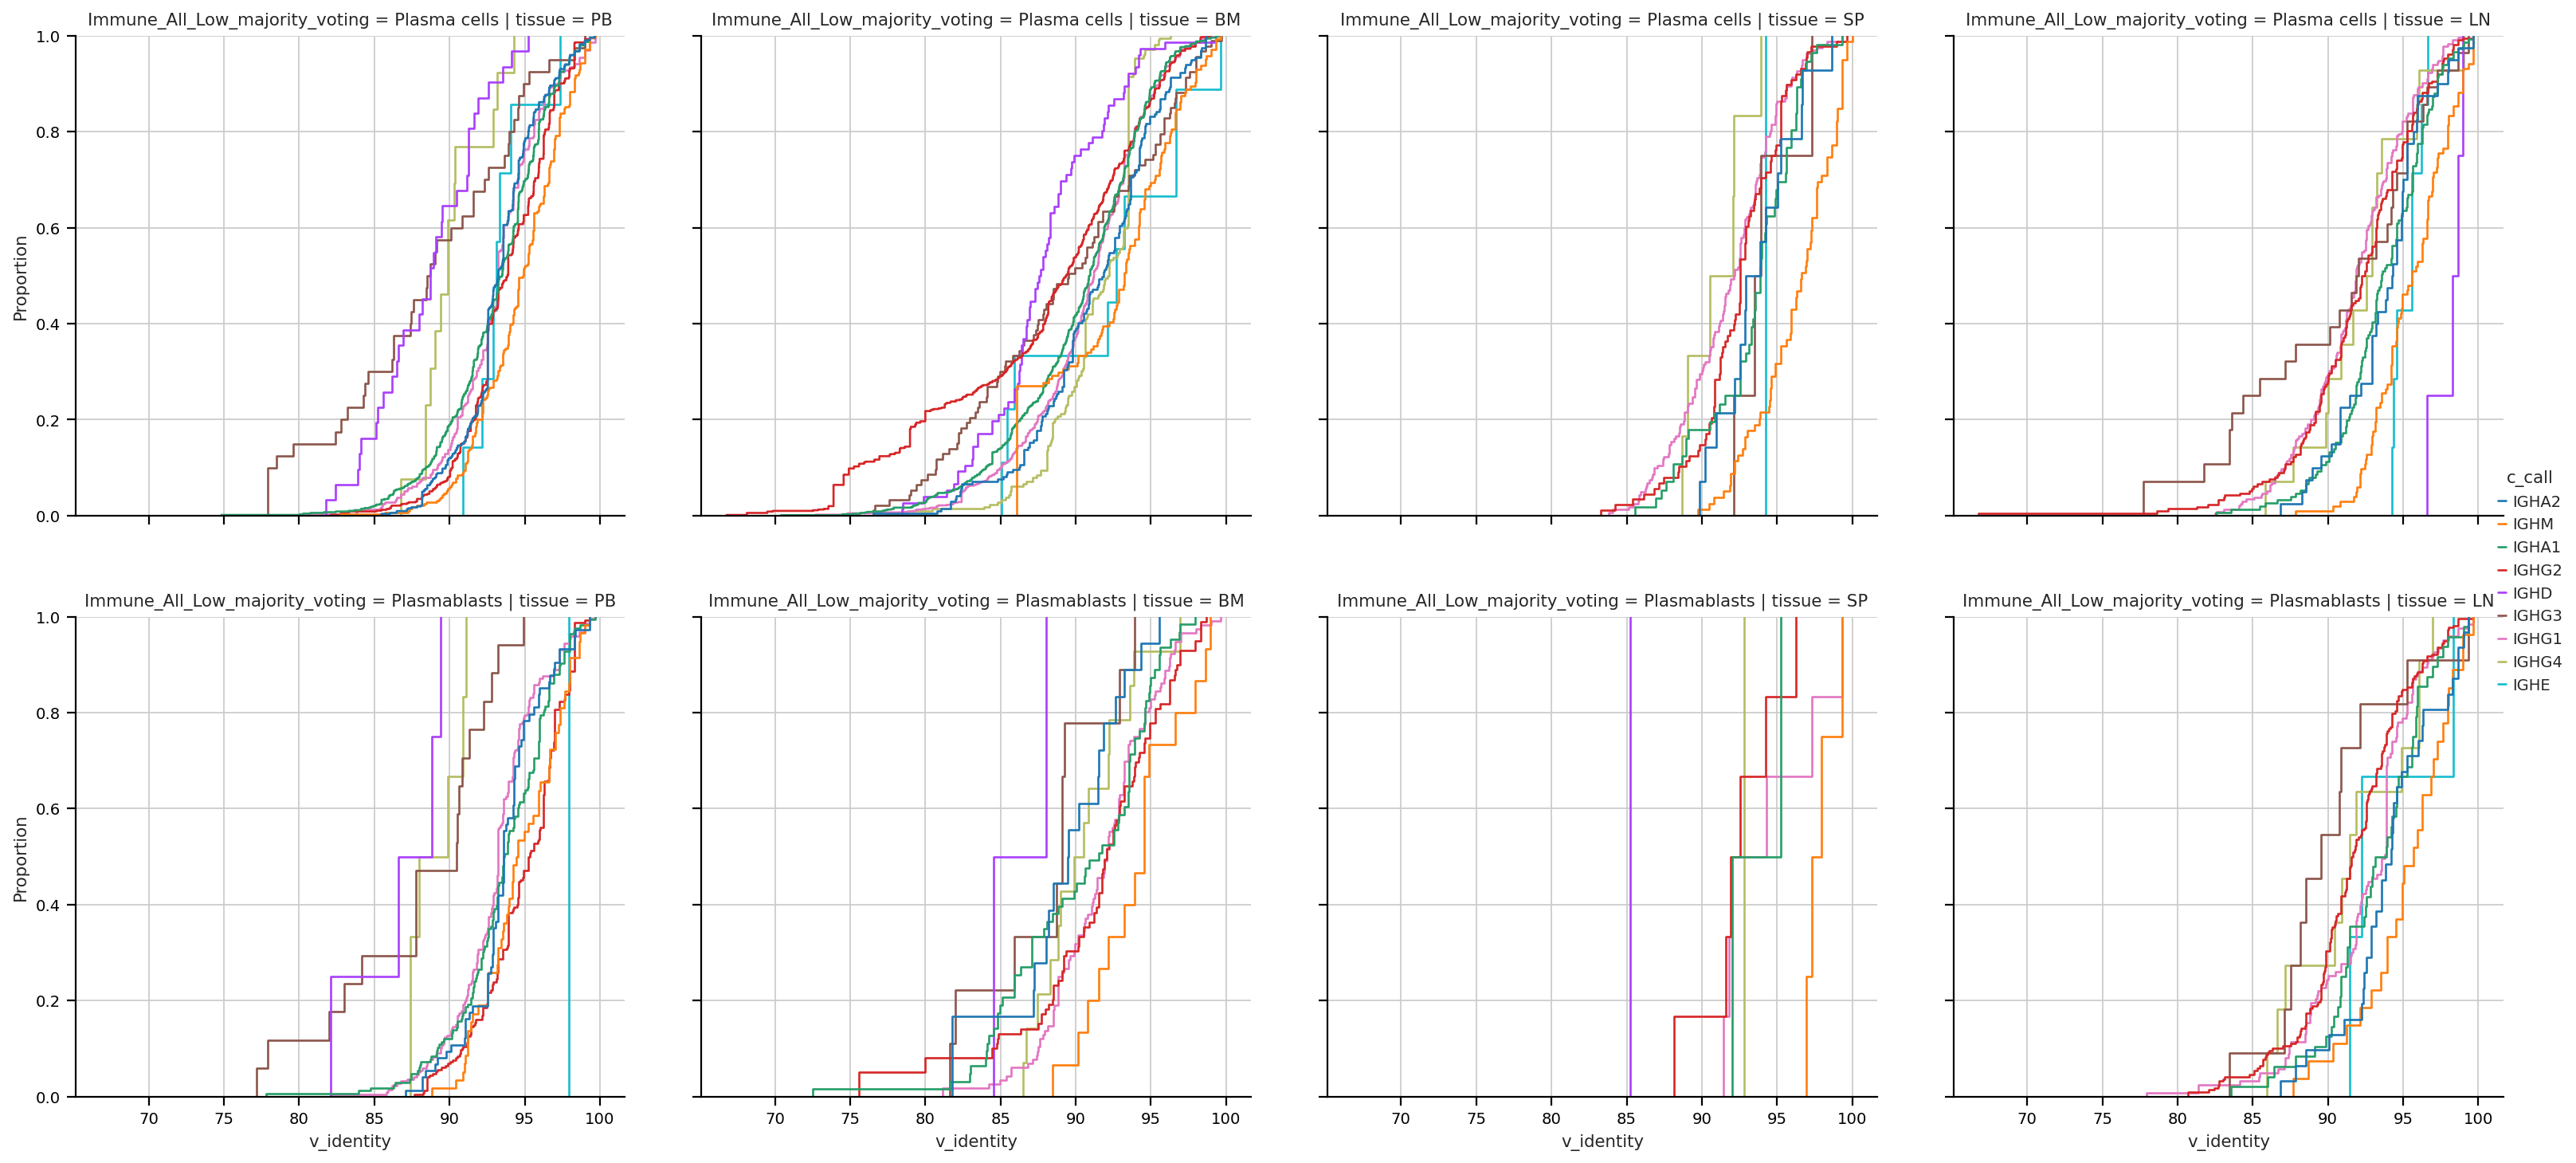

In [214]:
sns.set_context('paper')
data = obs_df
data = data[data.c_call.isin(igh_genes)]
data = data[data.Immune_All_Low_majority_voting.str.contains('Plasma')]
#fig, axs = plt.subplots(1, 2, figsize=(5, 5), sharey=True)
g = sns.displot(data, x="v_identity", hue="c_call", kind = 'ecdf', row = 'Immune_All_Low_majority_voting', col='tissue', height=5)
g.fig.tight_layout(pad = 4)

<AxesSubplot:xlabel='v_identity', ylabel='tissue'>

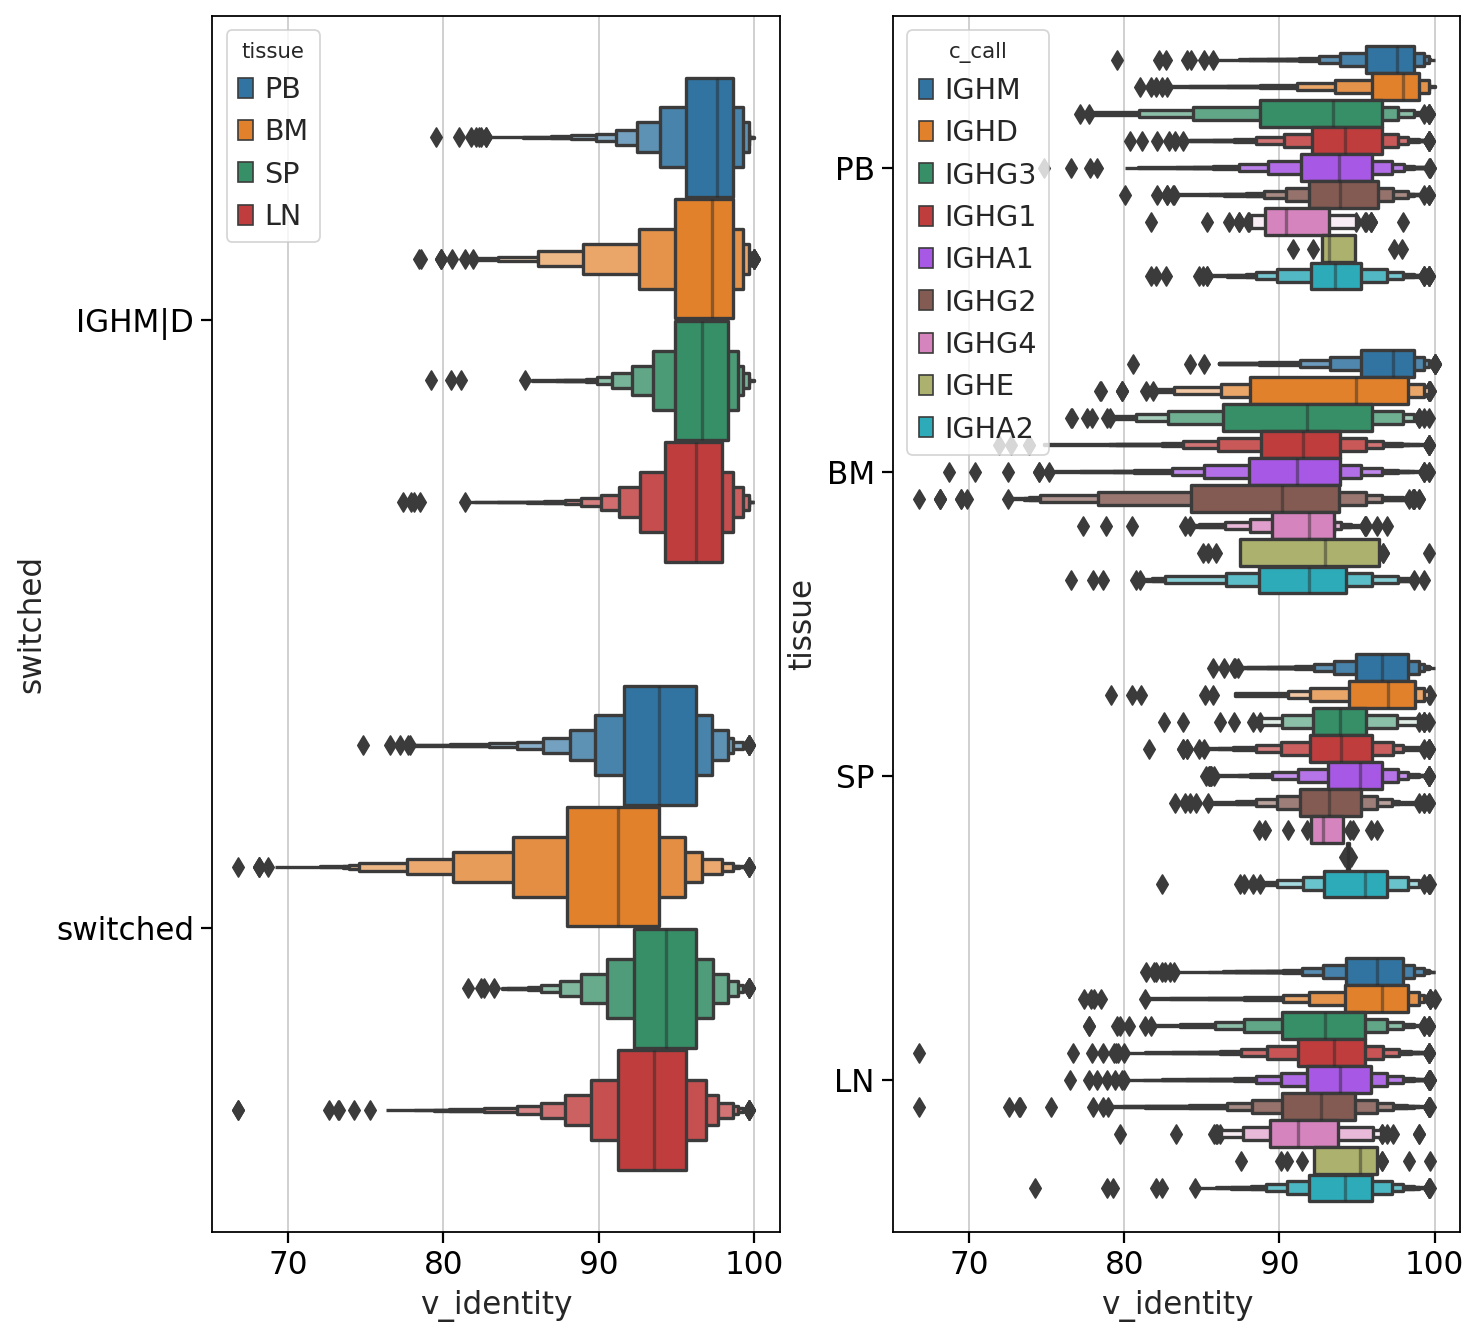

In [154]:
data = obs_df
data = data[data.c_call.isin(igh_genes)]
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
sns.boxenplot(data, y="switched", x="v_identity", hue="tissue", ax=axs[0])
sns.boxenplot(
    data, y="tissue", x="v_identity", hue="c_call", ax=axs[1], hue_order=igh_genes
)

In [215]:
celltype_label = "Immune_All_Low_predicted_labels"
COI = "c_call"

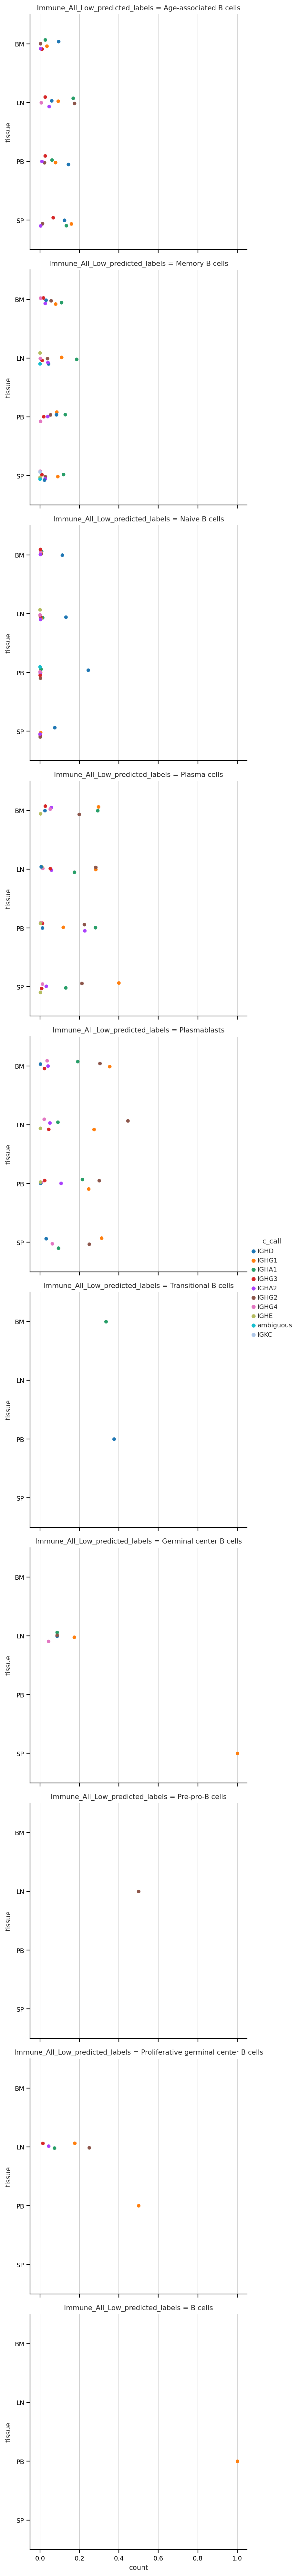

In [216]:
data = obs_df.groupby(["tissue", "Immune_All_Low_predicted_labels"])[COI].value_counts(
    normalize=True
)

data = pd.DataFrame(data)

data.columns = ["count"]
data = data.reset_index()

data = data[data[celltype_label].str.contains("B cell|Plasma")]
data = data[data[COI] != "IGHM"]

sns.catplot(data, x="count", y="tissue", hue=COI, row="Immune_All_Low_predicted_labels")

In [219]:
count = 'switched'
data = obs_df.groupby(
        ["probable_hq_single_b_cell", "Immune_All_Low_predicted_labels", "sample_uid"]
    )[count].value_counts(normalize=True).xs([True, "Naive B cells"])
data.name = 'proportion'
#g = sns.catplot(data = np.log10(data).reset_index(), y = 'c_call', x = 'proportion', row = 'sample_uid', sharex=False)


In [220]:
ambient_df = pd.read_table('/home/michaelswift/repos/tabula-bursa/data/gex_labels/ambient_rate_and_prob_own_vdj_by_celltype_common.tsv', index_col=0)
unswitched_in_ambient = pd.read_table('/home/michaelswift/repos/tabula-bursa/data/gex_labels/rate_of_unswitched_vdj_in_ambient.tsv', index_col=0)

df = pd.merge(data.loc[:, 'switched'], ambient_df, left_on='sample_uid', right_on='sample_uid')
df = pd.merge(df, unswitched_in_ambient, on='sample_uid')

In [221]:
plot_data = df[df.Immune_All_Low_predicted_labels == 'Naive B cells']
plot_data['corrected_proportion'] = plot_data['proportion']/(1 - plot_data['not_switched']+10**-5)

<ipython-input-221-3e72a495fc8c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['corrected_proportion'] = plot_data['proportion']/(1 - plot_data['not_switched']+10**-5)


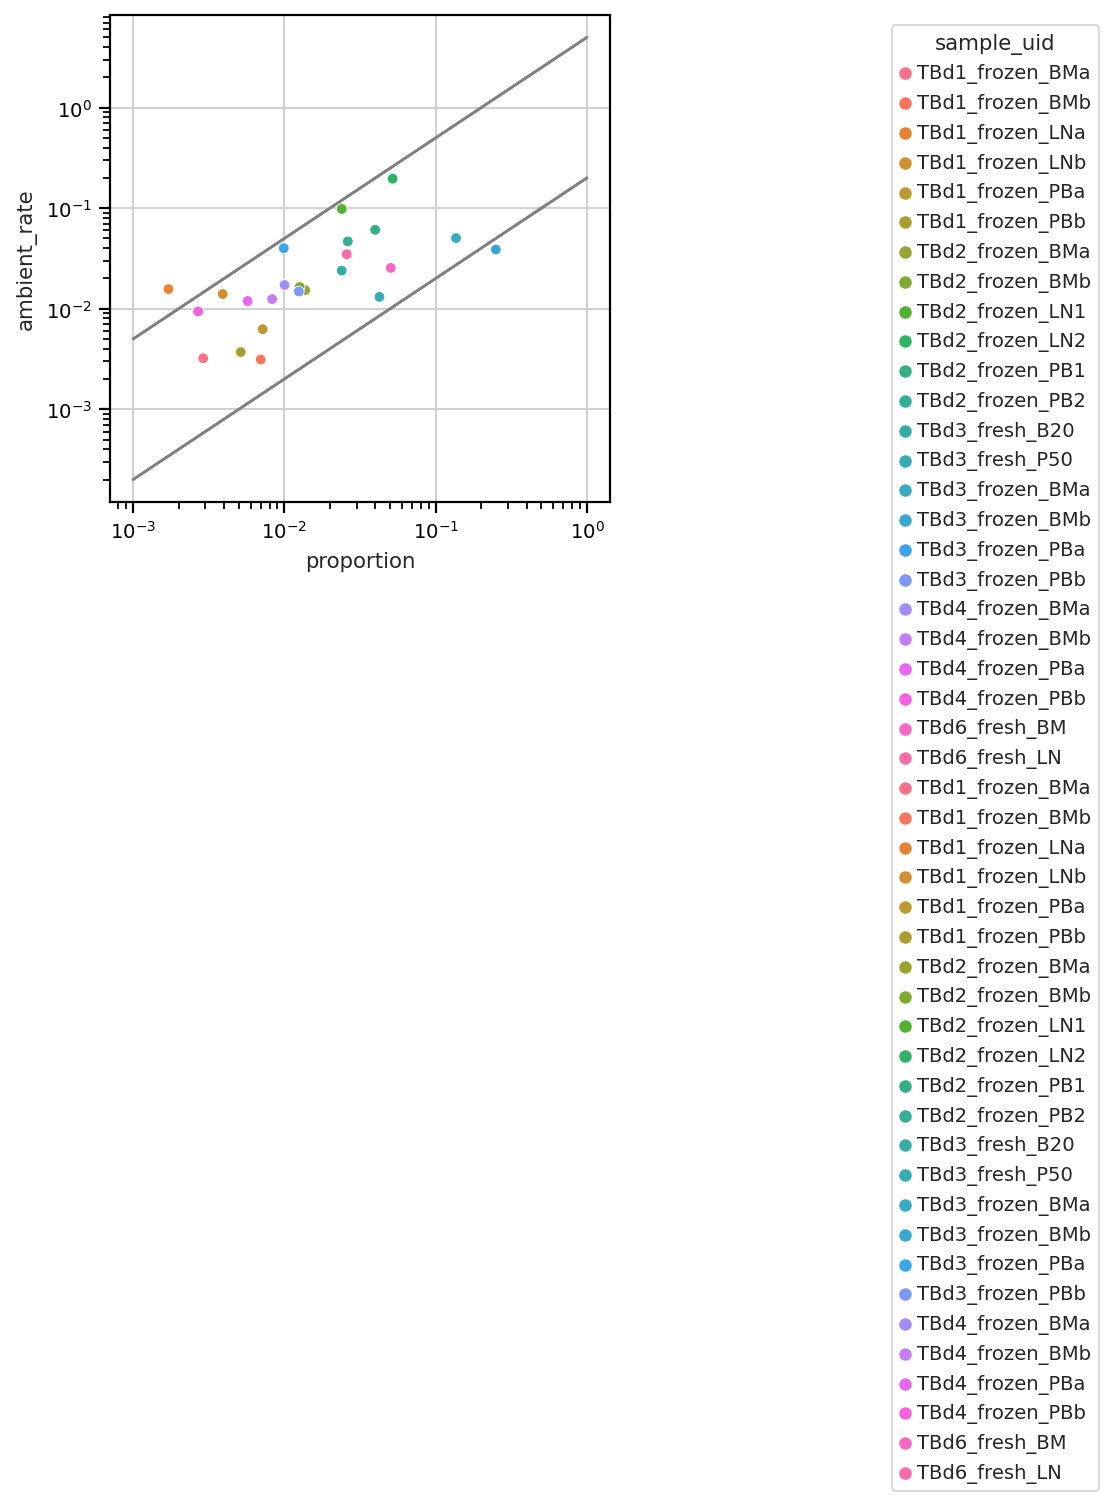

In [222]:
g = sns.scatterplot(data = plot_data, x = 'proportion', y= 'ambient_rate', hue='sample_uid')
plt.xscale('log')
plt.yscale('log')
xs = np.logspace(-3,0,20,base=10)
ys_lower=0.2*xs
ys_upper = 5*xs
g.axes.plot(xs,ys_lower, color='0.5')
g.axes.plot(xs,ys_upper, color='0.5')
sns.move_legend(g, bbox_to_anchor=(2,1), loc='upper right')

g = sns.scatterplot(data = plot_data, x = 'proportion', y= 'ambient_rate', hue='sample_uid')
plt.xscale('log')
plt.yscale('log')
xs = np.logspace(-3,0,20,base=10)
ys_lower=0.2*xs
ys_upper = 5*xs
g.axes.plot(xs,ys_lower, color='0.5')
g.axes.plot(xs,ys_upper, color='0.5')
sns.move_legend(g, bbox_to_anchor=(2,1), loc='upper right')

In [223]:
plot_data.loc[:,'inverse_p_real_vdj'] = 1 - plot_data.p_real_vdj

<ipython-input-223-4fabd96116db>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data.loc[:,'inverse_p_real_vdj'] = 1 - plot_data.p_real_vdj


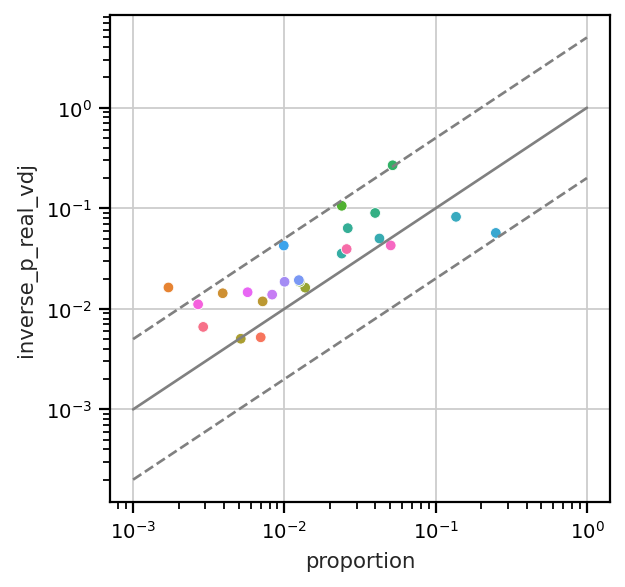

In [225]:
g = sns.scatterplot(data = plot_data, x = 'proportion', y= 'inverse_p_real_vdj', hue='sample_uid', legend=False)
plt.xscale('log')
plt.yscale('log')
xs = np.logspace(-3,0,20,base=10)
ys_lower=0.2*xs
ys_upper = 5*xs
g.axes.plot(xs,ys_lower,  '--', color='0.5',)
g.axes.plot(xs,ys_upper, '--', color='0.5', )
g.axes.plot(xs,xs, color='0.5')

#sns.move_legend(g, bbox_to_anchor=(2,1), loc='upper right')

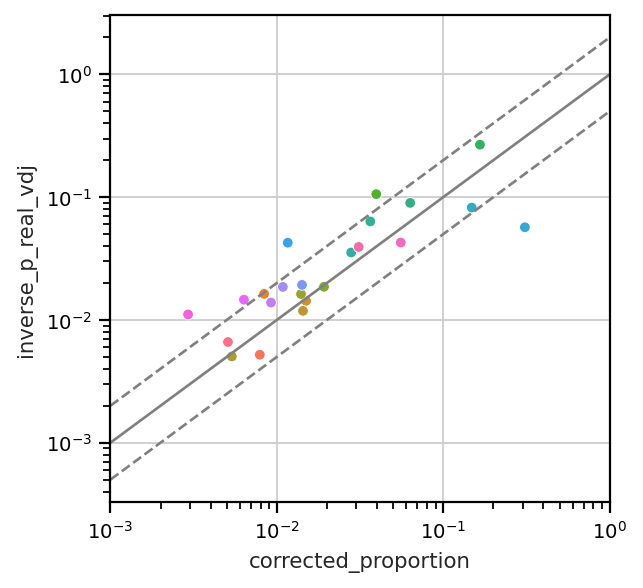

In [233]:
g = sns.scatterplot(data = plot_data, x = 'corrected_proportion', y= 'inverse_p_real_vdj', hue='sample_uid', legend=False)
plt.xscale('log')
plt.yscale('log')
xs = np.logspace(-3,0,20,base=10)
ys_lower=0.5*xs
ys_upper = 2*xs
g.axes.set_xlim([10**-3,1])
g.axes.plot(xs,ys_lower,  '--', color='0.5',)
g.axes.plot(xs,ys_upper, '--', color='0.5', )
g.axes.plot(xs,xs, color='0.5')


count = 'switched'
data = obs_df.groupby(
        ["probable_hq_single_b_cell", "Immune_All_Low_predicted_labels", "sample_uid"]
    )[count].value_counts(normalize=True).xs([True, "Naive B cells"])
data.name = 'proportion'
g = sns.catplot(data = np.log10(data).reset_index(), y = count, x = 'proportion', row = 'sample_uid', sharex=False)


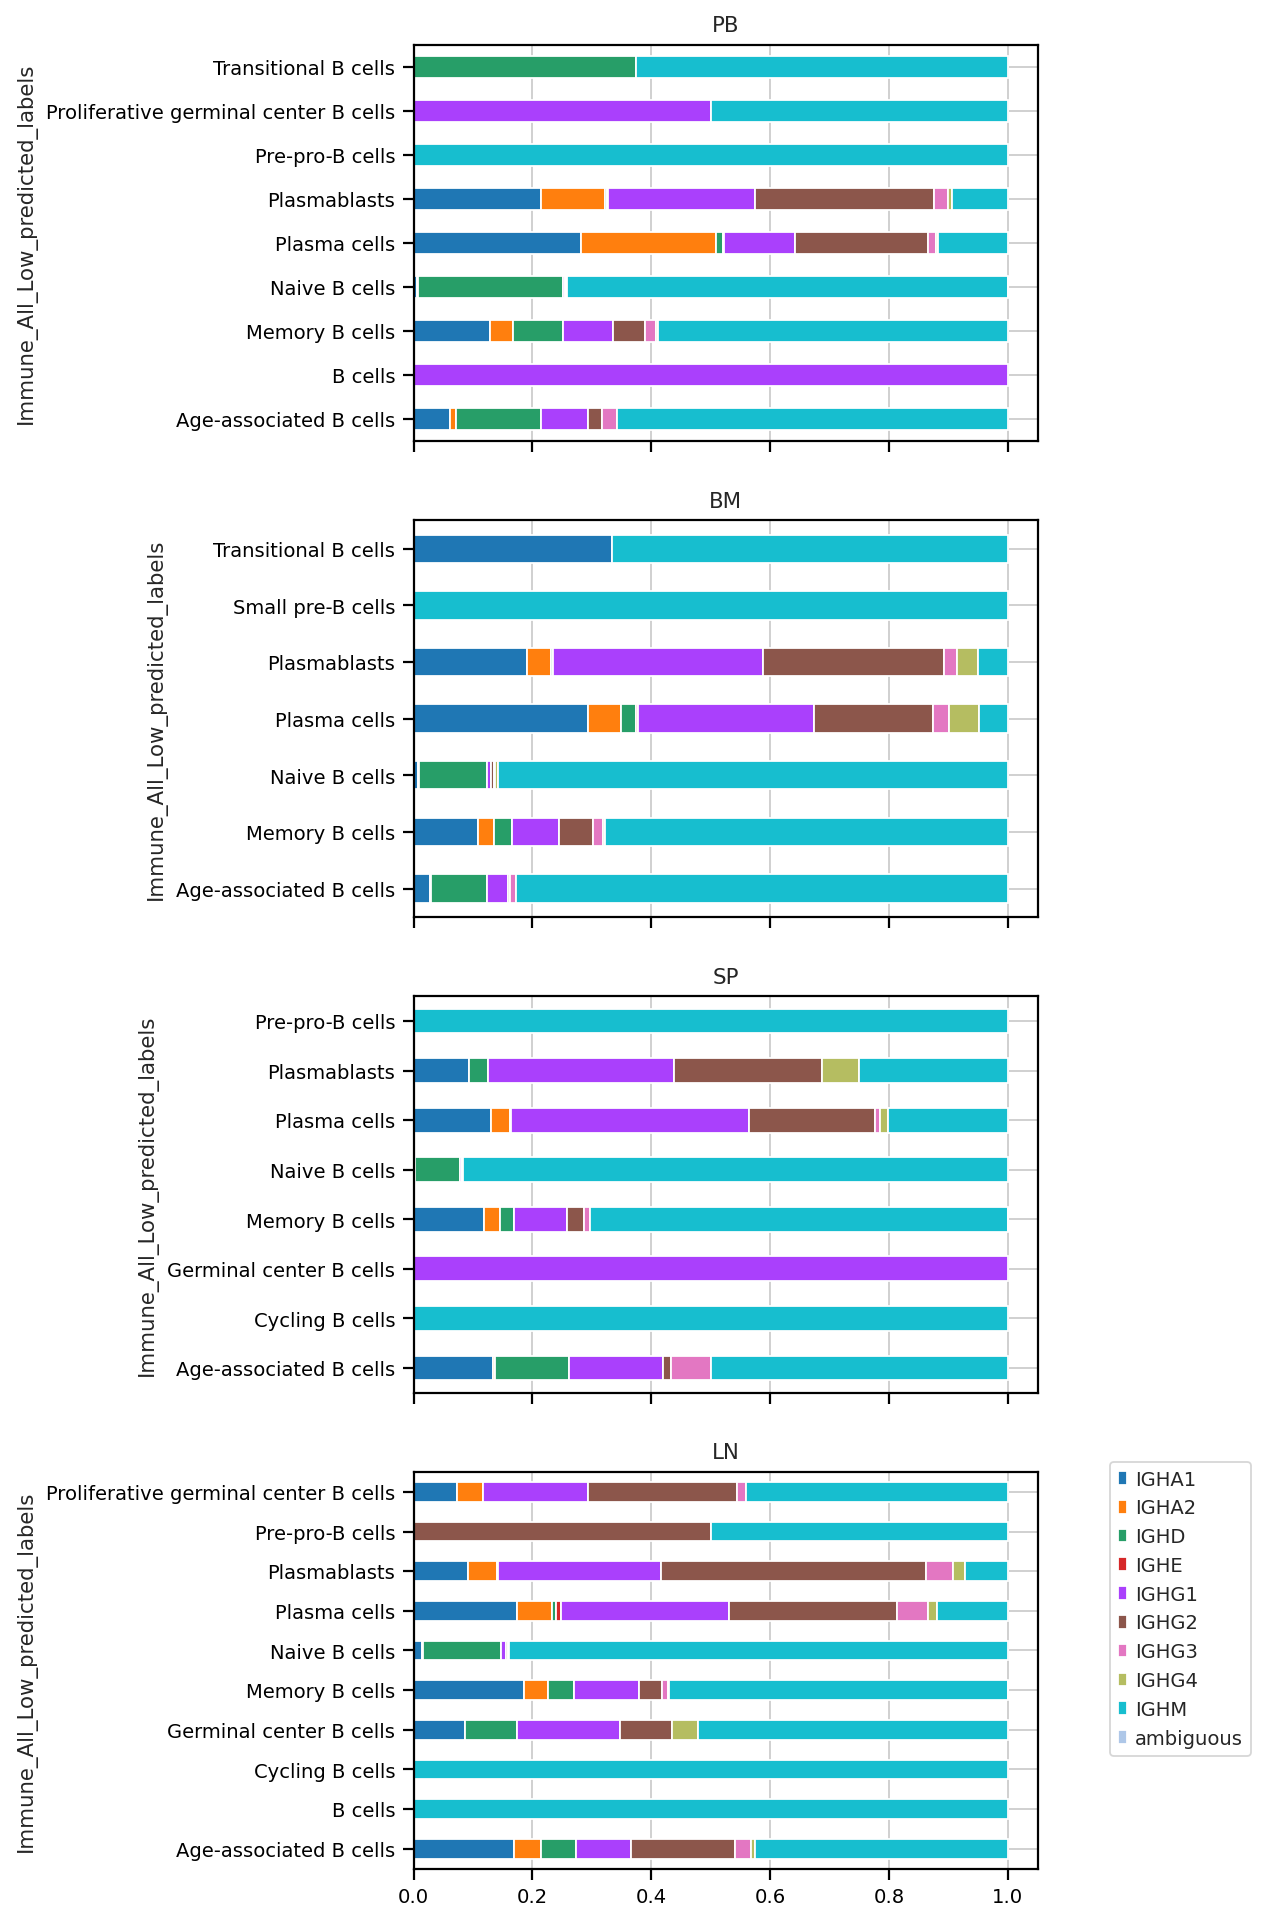

In [260]:
celltype_label = "Immune_All_Low_predicted_labels"
COI = "c_call"
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(5, 15))
for i, tissue in enumerate(obs_df.tissue.unique()):
    data = obs_df[obs_df.tissue == tissue]
    # print(data['tissue'])
    data = pd.DataFrame(data.groupby(celltype_label)[COI].value_counts(normalize=True))
    data.columns = ["fraction"]
    data = data.reset_index()
    data = data.pivot_table(values="fraction", index=celltype_label, columns=COI)
    data = data.loc[data.index.str.contains("B cells|Plasma")]
    if i < 3:
        flag = False
        data.plot(
            kind="barh",
            stacked=True,
            ax=axs[i],
            legend=flag,
            sort_columns=True,
            title=tissue,
        )
    else:
        flag = True
        ax = data.plot(
            kind="barh",
            stacked=True,
            ax=axs[i],
            legend=flag,
            sort_columns=True,
            title=tissue,
        )
        ax.legend(bbox_to_anchor=(1.1, 1.05))

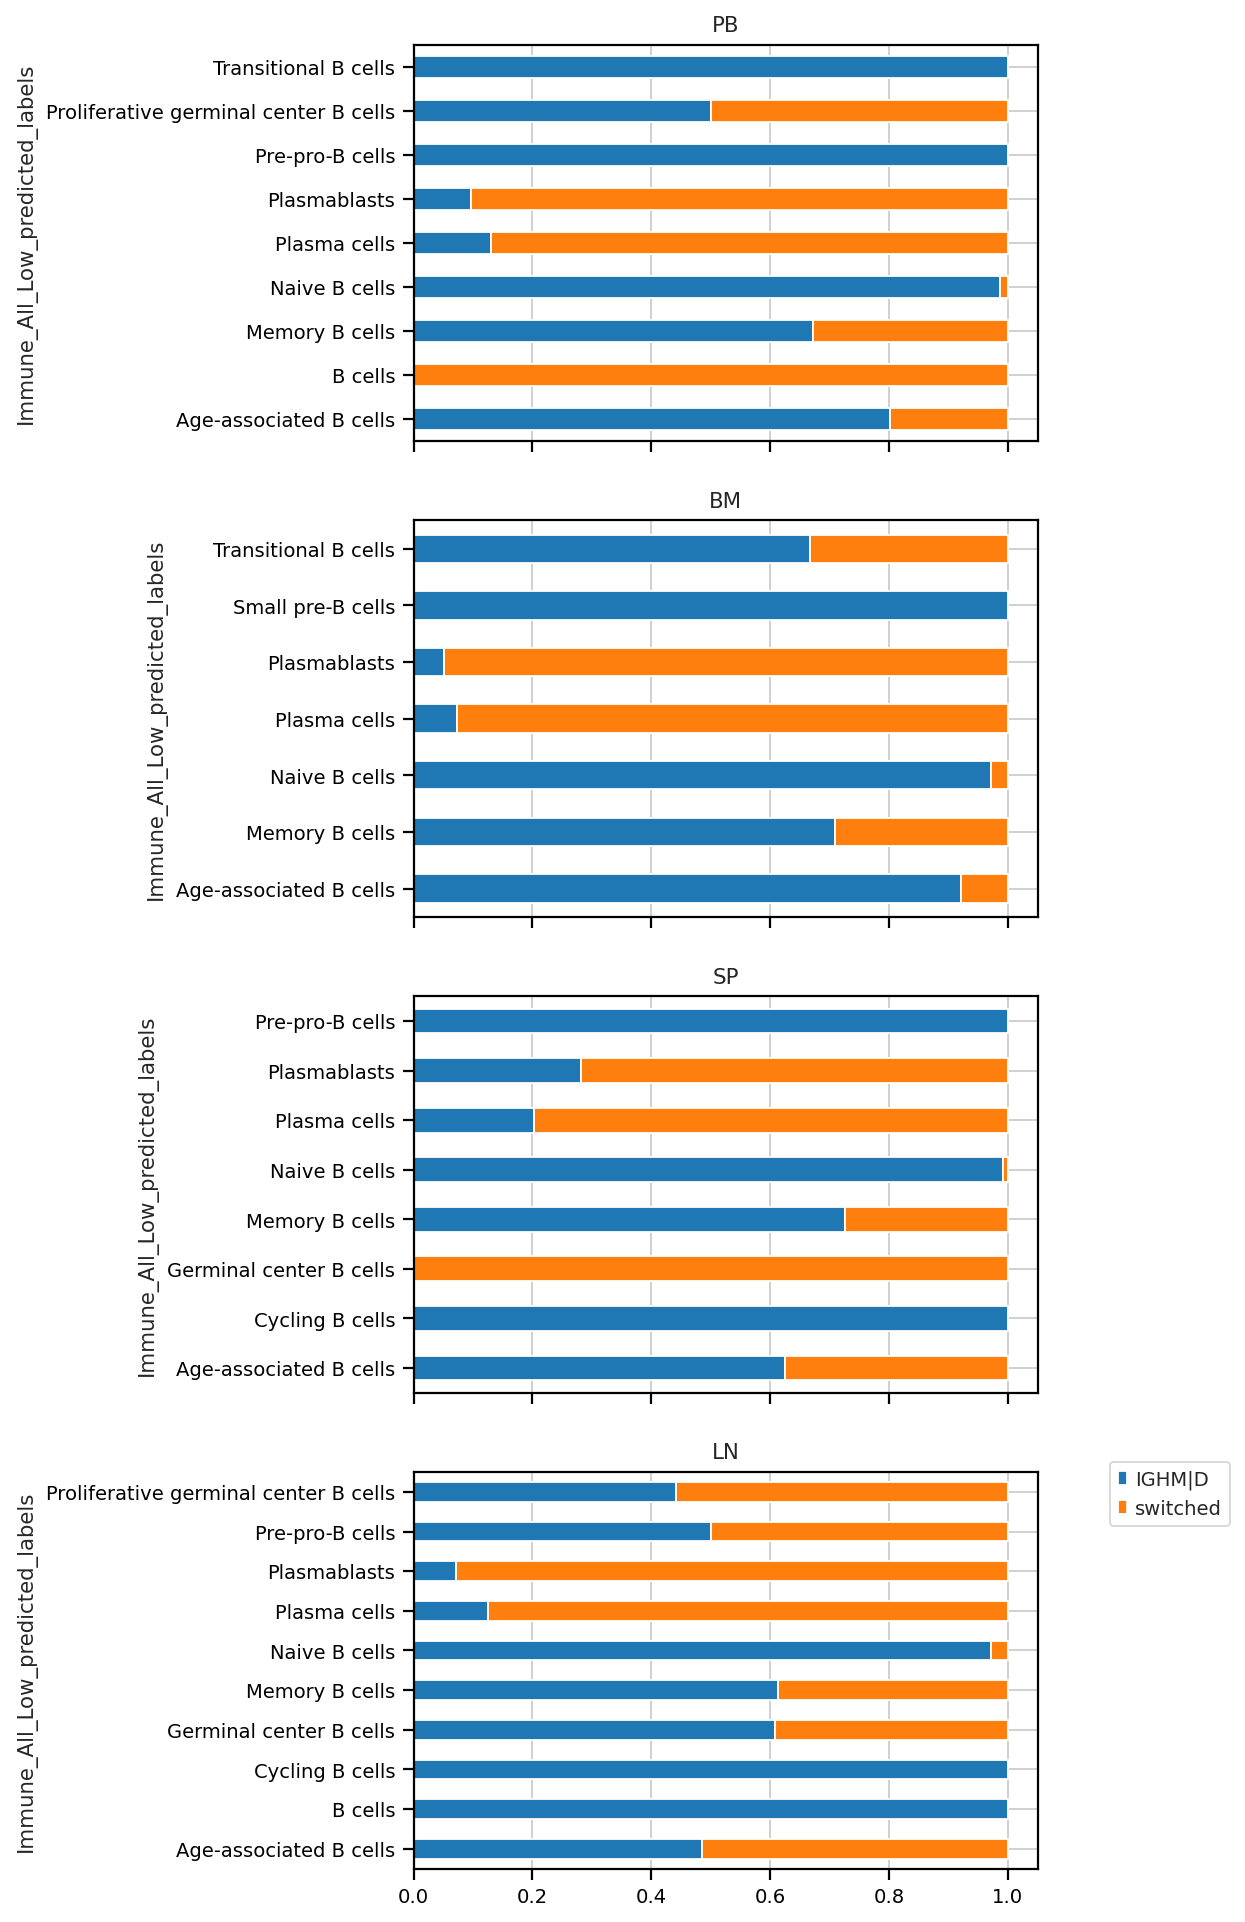

In [261]:
celltype_label = "Immune_All_Low_predicted_labels"
COI = "switched"
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(5, 15))
for i, tissue in enumerate(obs_df.tissue.unique()):
    data = obs_df[obs_df.tissue == tissue]
    # print(data['tissue'])
    data = pd.DataFrame(data.groupby(celltype_label)[COI].value_counts(normalize=True))
    data.columns = ["fraction"]
    data = data.reset_index()
    data = data.pivot_table(values="fraction", index=celltype_label, columns=COI)
    data = data.loc[data.index.str.contains("B cells|Plasma")]
    if i < 3:
        flag = False
        data.plot(
            kind="barh",
            stacked=True,
            ax=axs[i],
            legend=flag,
            sort_columns=True,
            title=tissue,
        )
    else:
        flag = True
        ax = data.plot(
            kind="barh",
            stacked=True,
            ax=axs[i],
            legend=flag,
            sort_columns=True,
            title=tissue,
        )
        ax.legend(bbox_to_anchor=(1.1, 1.05))

In [ ]:
celltype_label = "Immune_All_Low_predicted_labels"
COI = "switched"
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(5, 15))
for i, tissue in enumerate(obs_df.tissue.unique()):
    data = obs_df[obs_df.tissue == tissue]
    # print(data['tissue'])
    data = pd.DataFrame(data.groupby(celltype_label)[COI].value_counts(normalize=True))
    data.columns = ["fraction"]
    data = data.reset_index()
    data = data.pivot_table(values="fraction", index=celltype_label, columns=COI)
    data = data.loc[data.index.str.contains("B cells|Plasma")]
    if i < 3:
        flag = False
        data.plot(
            kind="barh",
            stacked=True,
            ax=axs[i],
            legend=flag,
            sort_columns=True,
            title=tissue,
        )
    else:
        flag = True
        ax = data.plot(
            kind="barh",
            stacked=True,
            ax=axs[i],
            legend=flag,
            sort_columns=True,
            title=tissue,
        )
        ax.legend(bbox_to_anchor=(1.1, 1.05))

In [278]:
obs_df.loc[:,'lineage_size'] = obs_df.lineage_id.map(obs_df.lineage_id.value_counts().to_dict())

In [291]:
obs_df.loc[:,"cycling_cat"] = obs_df.cycling.astype(str)

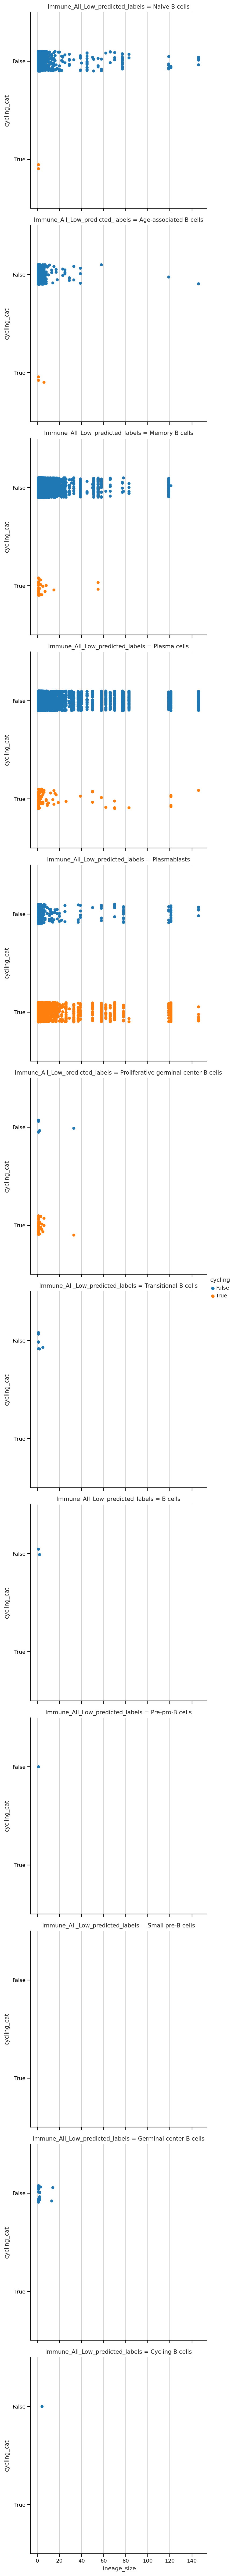

In [297]:
sns.catplot(data = obs_df, x = 'lineage_size', y = 'cycling_cat', row = 'Immune_All_Low_predicted_labels', hue = 'cycling')

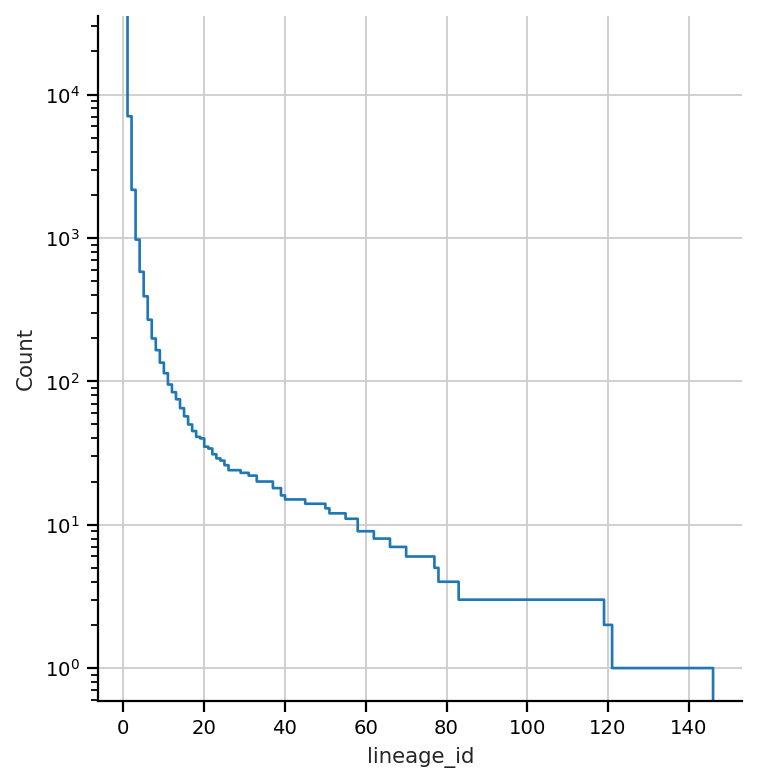

In [272]:
sns.displot(obs_df['lineage_id'].value_counts(), kind = 'ecdf', complementary = True, stat='count')
plt.yscale("log")

In [254]:
obs_df.groupby(['sample_uid', "Immune_Low_predicted_labels"]).c_call.value_counts(normalize = True)

sample_uid       Immune_All_Low_predicted_labels        c_call
TBd1_frozen_BMa  Age-associated B cells                 IGHD      0.333333
                                                        IGHG1     0.333333
                                                        IGHM      0.333333
                 Memory B cells                         IGHM      0.842105
                                                        IGHD      0.070175
                                                                    ...   
TBd6_fresh_LN    Proliferative germinal center B cells  IGHM      0.312500
                                                        IGHG1     0.250000
                                                        IGHG2     0.250000
                                                        IGHA1     0.125000
                                                        IGHG3     0.062500
Name: c_call, Length: 888, dtype: float64

KeyError: 'tissue'

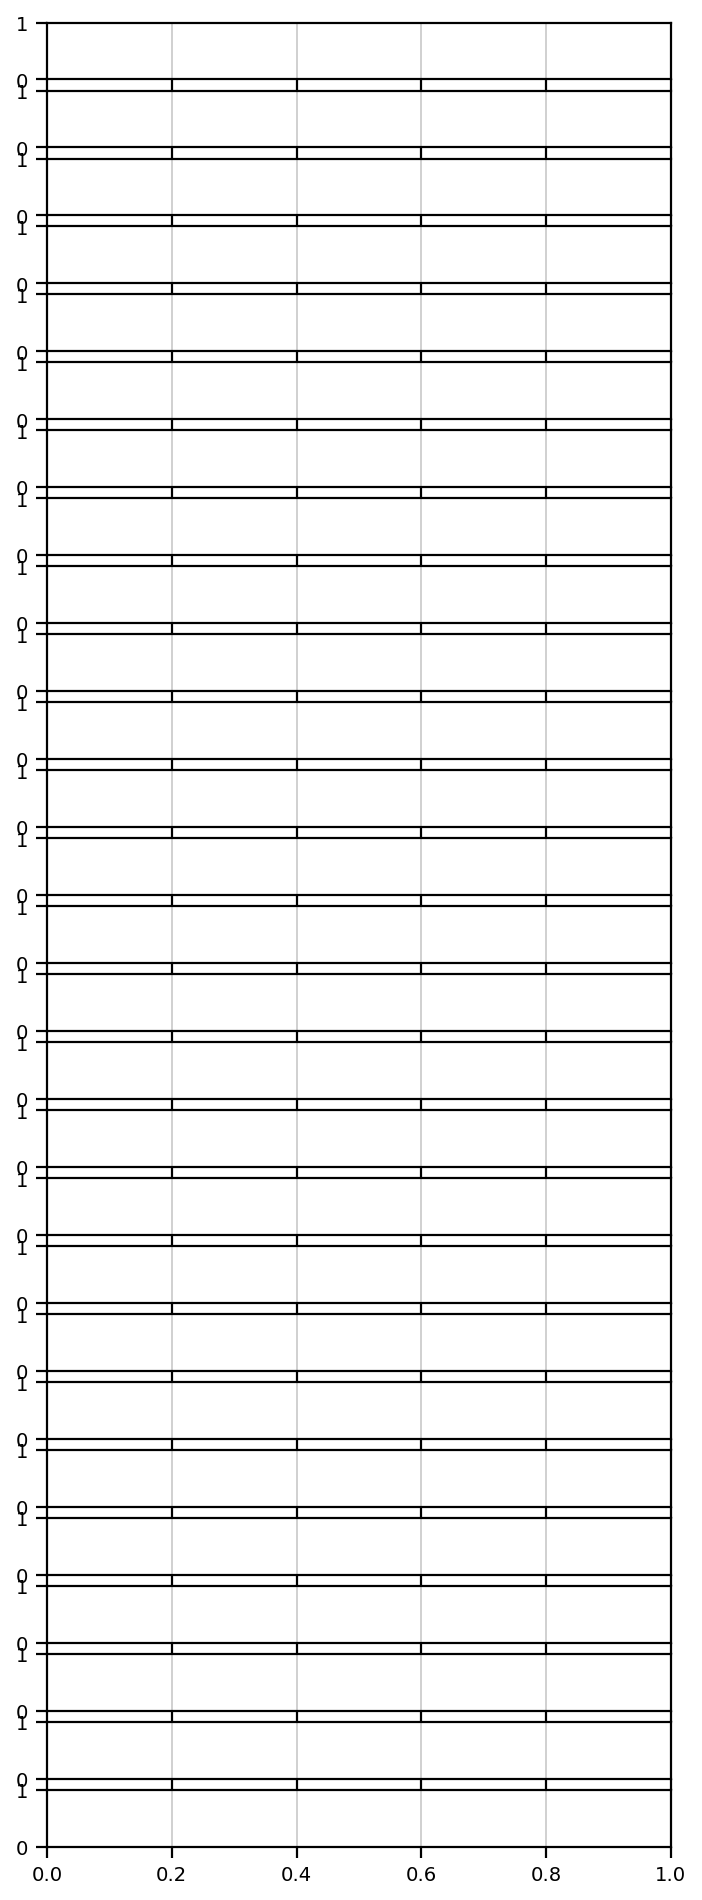

In [248]:
y_label = "tissue"
row = "sample_uid"
COI = "c_call"
num_plots = obs_df[row].unique().shape[0]
fig, axs = plt.subplots(num_plots, 1, sharex=True, figsize=(5, 15))
for i, r in enumerate(obs_df[row].unique()):
    data = obs_df[obs_df[row] == r]
    data = pd.DataFrame(data.groupby(row_)[COI].value_counts(normalize=True))
    data.columns = ["fraction"]
    data = data.reset_index()
    data = data.pivot_table(values="fraction", index=y_label, columns=COI)
    if i < num_plots:
        flag = False
        data.plot(
            kind="barh",
            stacked=True,
            ax=axs[i],
            legend=flag,
            sort_columns=True,
      
        )
        plt.ylabel(r)
    else:
        flag = True
        ax = data.plot(
            kind="barh",
            stacked=True,
            ax=axs[i],
            legend=flag,
            sort_columns=True,
        )
        ax.legend(bbox_to_anchor=(1.1, 1.05))

In [249]:
data

c_call,IGHA1,IGHA2,IGHD,IGHE,IGHG1,IGHG2,IGHG3,IGHG4,IGHM,ambiguous
tissue,,,,,,,,,,
LN,0.088938,0.022724,0.040878,0.000131,0.107483,0.101345,0.022202,0.002873,0.613295,0.000131


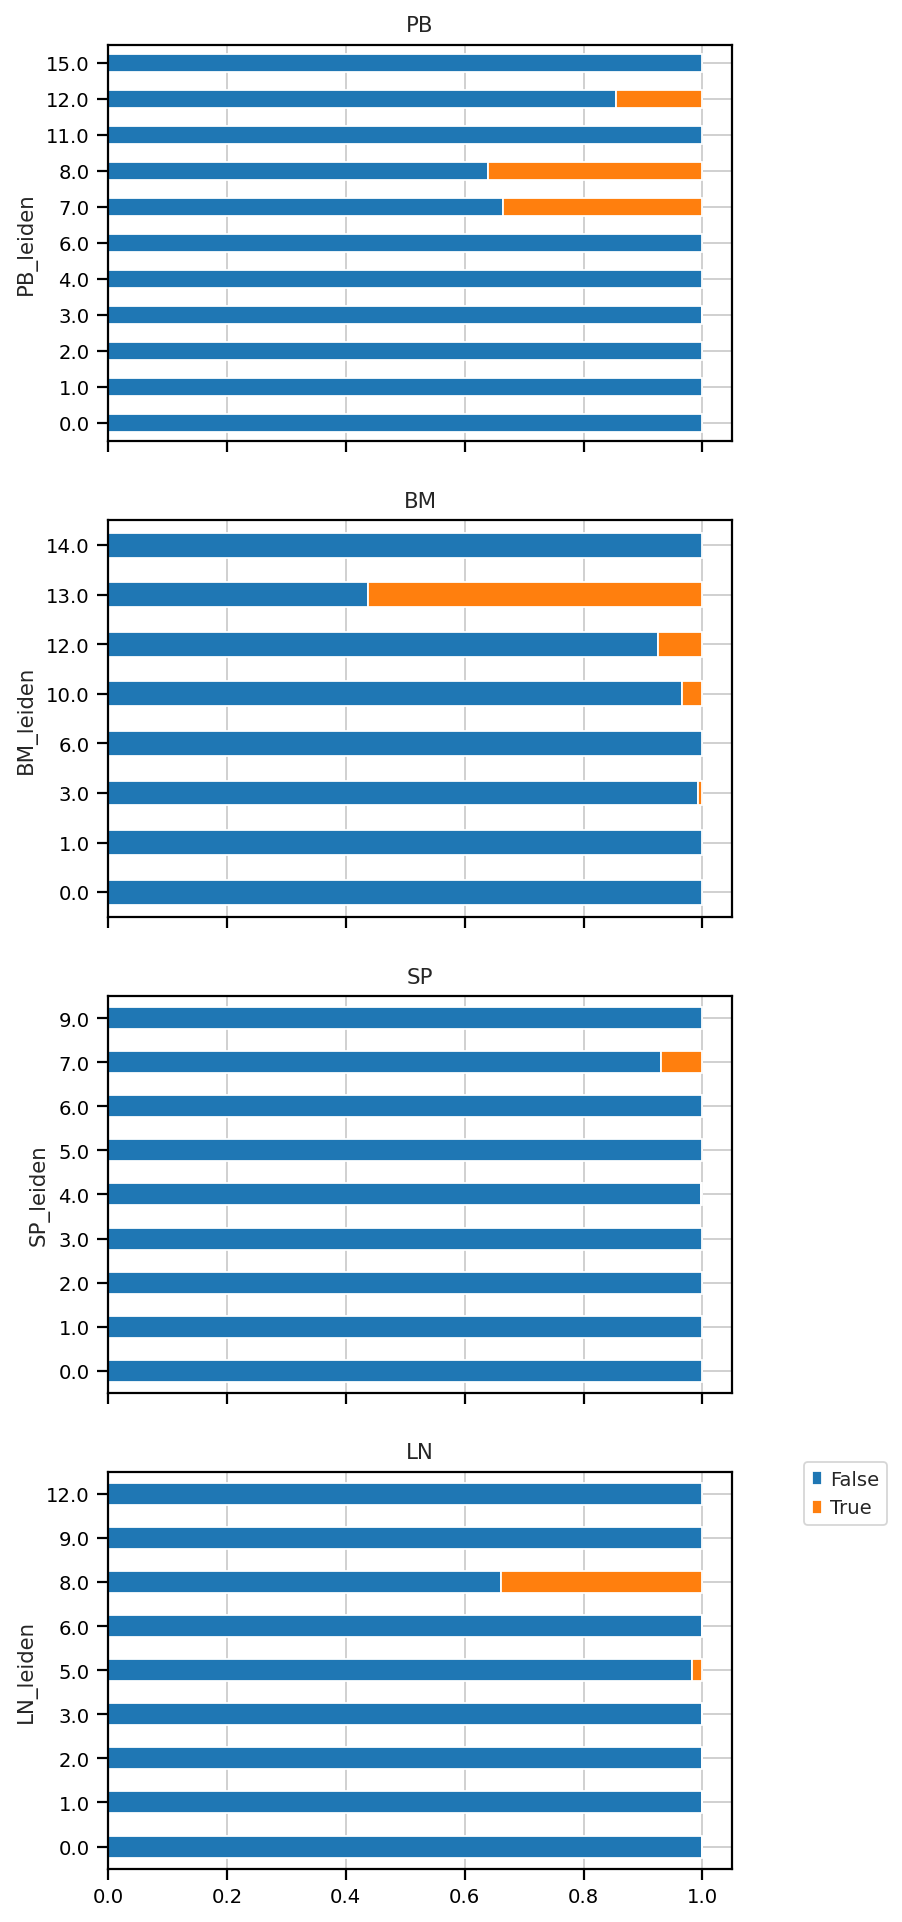

In [237]:
celltype_label = "Immune_All_Low_predicted_labels"
COI = "cycling"
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(5, 15))
for i, tissue in enumerate(obs_df.tissue.unique()):
    data = obs_df[obs_df.tissue == tissue]
    # print(data['tissue'])
    celltype_label = "{}_leiden".format(tissue)

    data = pd.DataFrame(data.groupby(celltype_label)[COI].value_counts(normalize=True))
    data.columns = ["fraction"]
    data = data.reset_index()
    data = data.pivot_table(values="fraction", index=celltype_label, columns=COI)
    # data = data.loc[data.index.str.contains("B cells|Plasma")]
    if i < 3:
        flag = False
        data.plot(
            kind="barh",
            stacked=True,
            ax=axs[i],
            legend=flag,
            sort_columns=True,
            title=tissue,
        )
    else:
        flag = True
        ax = data.plot(
            kind="barh",
            stacked=True,
            ax=axs[i],
            legend=flag,
            sort_columns=True,
            title=tissue,
        )
        ax.legend(bbox_to_anchor=(1.1, 1.05))

In [ ]:
celltype_label = "Immune_All_Low_predicted_labels"
COI = "cycling"
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(5, 15))
for i, tissue in enumerate(obs_df.tissue.unique()):
    data = obs_df[obs_df.tissue == tissue]
    # print(data['tissue'])
    celltype_label = "{}_leiden".format(tissue)

    data = pd.DataFrame(data.groupby(celltype_label)[COI].value_counts(normalize=True))
    data.columns = ["fraction"]
    data = data.reset_index()
    data = data.pivot_table(values="fraction", index=celltype_label, columns=COI)
    # data = data.loc[data.index.str.contains("B cells|Plasma")]
    if i < 3:
        flag = False
        data.plot(
            kind="barh",
            stacked=True,
            ax=axs[i],
            legend=flag,
            sort_columns=True,
            title=tissue,
        )
    else:
        flag = True
        ax = data.plot(
            kind="barh",
            stacked=True,
            ax=axs[i],
            legend=flag,
            sort_columns=True,
            title=tissue,
        )
        ax.legend(bbox_to_anchor=(1.1, 1.05))

In [ ]:
obs_df.groupby(["tissue", celltype_label])["c_call"].value_counts()

In [ ]:
for index, group in obs_df.groupby(["tissue", celltype_label]):
    cell = data.loc[data.index.str.contains("B cells|Plasma")]

In [ ]:
obs_df.groupby(["tissue", "Immune_All_Low_predicted_labels"])["c_call"].value_counts(
    normalize=True
).xs(["LN", "Memory B cells"])

In [ ]:
celltype_label = "Immune_All_Low_predicted_labels"
COI = "cycling"

df = pd.DataFrame(
    adata.obs.groupby(celltype_label)[COI].value_counts(normalize=True)
).reset_index()

data = df.pivot_table(values=COI, index=celltype_label, columns="level_1")
# set seaborn plotting aesthetics
# subset to timecourse & put in order
res_arr = np.flip(pseudo_timecourse)
# color = mutation_colors
data = data.loc[data.index.str.contains("B cells|Plasma")]

ax = data.plot(kind="barh", stacked=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
locs, labels = plt.xticks()
plt.xlabel("Proportion of Cells")
plt.setp(labels, rotation=0)
fig = ax.get_figure()
save_figure(fig, "stacked_bar_mutation_dynamics")

In [ ]:
data = adata.obs
data = data[data[celltype_label].str.contains("B cells|Plasma")]
data.loc[:, celltype_label] = data[celltype_label].cat.remove_unused_categories()
COI = "c_call"
data = pd.DataFrame(
    data.groupby(celltype_label)[COI].value_counts(normalize=True)
).reset_index()

In [ ]:
data.columns = [celltype_label, COI, "value"]

In [ ]:
sns.catplot(data, y="value", hue=COI, x=celltype_label)
plt.xscale("log")

In [ ]:
sc.pl.umap(adata, color="Immune_All_Low_predicted_labels")

## umis by celltype

In [ ]:
adata.obs["log_n_umis"] = np.log(adata.obs["n_umis"])

In [ ]:
hue = "Immune_All_Low_predicted_labels"
data = adata.obs[adata.obs[hue].str.contains("Naive B|Memory B|Plasma|B cells")]
data[hue].cat.remove_unused_categories(inplace=True)
kind = "ecdf"
x = "log_n_umis"

g = sns.displot(
    data=data, x=x, kind=kind, hue=hue, col="probable_hq_single_b_cell", stat="count"
)
plt.yscale("log")
save_figure(g.fig, "{}_n_umis_{}".format(x, kind, hue))

In [ ]:
sc.tl.rank_genes_groups(adata, groupby="{}_leiden".format(tissue))

In [ ]:
# create ismple mutation status column
adata.obs.v_identity = adata.obs.v_identity.fillna(100)
adata.obs.loc[:, "simple_mutation_status"] = pd.cut(
    adata.obs.v_identity, bins=[0, 99, 100]
)

### B Cell Quality

In [ ]:
hue = "Immune_All_Low_predicted_labels"
data = adata.obs[adata.obs[hue].str.contains("Naive B|Memory B|Plasma|B cells")]
data[hue].cat.remove_unused_categories(inplace=True)
kind = "ecdf"
x = "v_identity"

g = sns.displot(
    data=data, x=x, kind=kind, hue=hue, col="probable_hq_single_b_cell", stat="count"
)
plt.yscale("log")
save_figure(g.fig, "{}_n_umis_{}".format(x, kind, hue))

In [ ]:
hue = "Immune_All_Low_predicted_labels"
data = adata.obs[adata.obs[hue].str.contains("B cells|Plasma")]
data[hue].cat.remove_unused_categories(inplace=True)
kind = "ecdf"
x = "v_identity"

g = sns.displot(
    data=data,
    x=x,
    kind=kind,
    hue=hue,
    col="probable_hq_single_b_cell",
    stat="proportion",
)
plt.yscale("log")
save_figure(g.fig, "{}_n_umis_{}".format(x, kind, hue))

## Cycling

In [ ]:
adata = adata[adata.obs.probable_hq_single_b_cell == "True"]

In [ ]:
# subset adata
label = "my_leiden_majority_voting"
groupby = "simple_mutation_status"
for celltype in adata.obs[label].cat.remove_unused_categories().unique():
    try:
        print(celltype)
        subset_adata = adata[adata.obs[label] == celltype]
        sc.tl.rank_genes_groups(subset_adata, groupby=groupby)
        sc.pl.rank_genes_groups(subset_adata)
        sc.pl.rank_genes_groups_dotplot(subset_adata, min_logfoldchange=1)
        sc.pl.rank_genes_groups_dotplot(subset_adata)
    except:
        pass
    print("\n \n \n \n")